In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

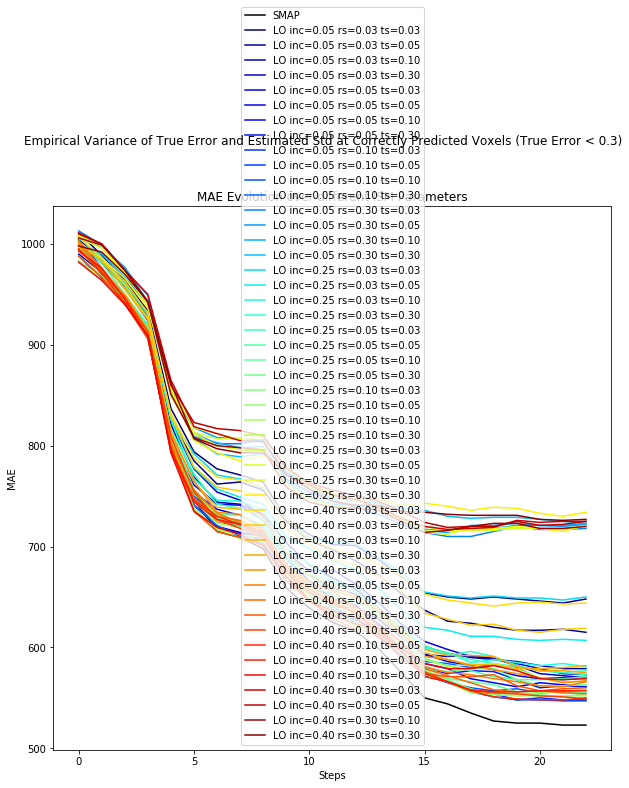

In [4]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle("Empirical Variance of True Error and Estimated Std at Correctly Predicted Voxels (True Error < 0.3)")

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]

for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
    if rnd == 0:
        errBelief = np.array(stats.errorEvolutionBelief)
        ax.plot(errBelief, color="black", label="SMAP")
        
    errLogOdds = np.array(stats.errorEvolutionLogOdds)
    ax.plot(errLogOdds, color=colors[rnd], label="LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize))
    
ax.set_title("MAE Evolution over different ISM Parameters")
ax.set_ylabel("MAE")
ax.set_xlabel("Steps")
ax.legend()

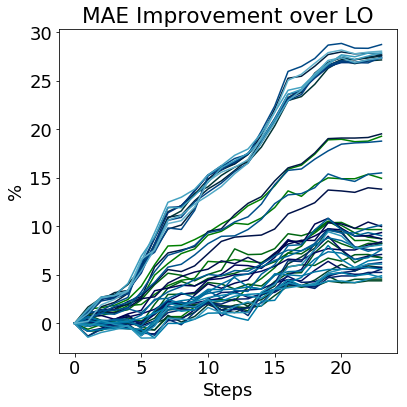

In [131]:
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 18})
fig, ((ax)) = plt.subplots(1, 1, figsize=(6, 6))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("ism_runs/"):])[0]))

gradient = np.linspace(0, 0.79, len(filenames))
colors = [cm.ocean(x) for x in gradient]

errLastBelief = 0

for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
    if rnd == 0:
        errBelief = np.array([1e-9] + list(stats.errorEvolutionBelief))
        errLastBelief = stats.errorEvolutionBelief[-1]
        
    errLogOdds = np.array([1e-9] + list(stats.errorEvolutionLogOdds))
    ax.plot((errLogOdds-errBelief)/errLogOdds*100, color=colors[rnd], label="LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize))
    
ax.set_title("MAE Improvement over LO")
ax.set_ylabel("%")
ax.set_xlabel("Steps")
# ax.legend()
plt.tight_layout()
plt.savefig("mae_logodds_improvement.pdf")

351.120244278


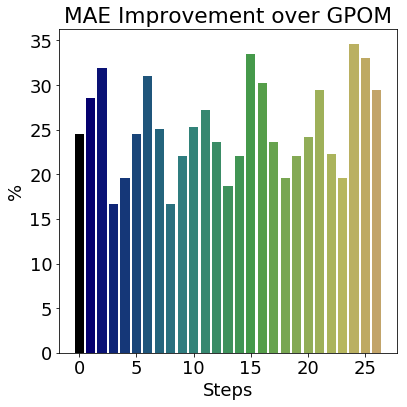

In [169]:
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 18})
fig, ((ax)) = plt.subplots(1, 1, figsize=(6, 6))

err_GP = []
std_GP = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("gp_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("gp_runs/"):])[0]))

gradient = np.linspace(0, 0.79, len(filenames))
colors = [cm.gist_earth(x) for x in gradient]

print smapError
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    errorGP = np.sum(np.abs(np.array(stats.errorGP))) #stats.errorEvolutionGP[-1] #np.sum(np.abs(np.array(stats.errorGP)))
    ax.bar([rnd], [(errorGP-smapError)/errorGP*100], color=colors[rnd],
            label="GP p1=%.2f p2=%.2f p3=%.2f" % (stats.gpParameter1, stats.gpParameter2, stats.gpParameter3))
    
ax.set_title("MAE Improvement over GPOM")
ax.set_ylabel("%")
ax.set_xlabel("Steps")
# ax.legend()
plt.tight_layout()
plt.savefig("mae_gp_improvement.pdf")

In [180]:
steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("sensor_noise_std/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("sensor_noise_std/"):])[0]))


print smapError
k = 1
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    
    print "##### Sensor noise std %.3f #####" % stats.noiseStd
        
    voxels = stats.voxels
    errorLO = np.sum(np.abs(np.array(stats.errorLogOdds)))/float(len(stats.errorLogOdds))
    errorGP = np.sum(np.abs(np.array(stats.errorGP)))/float(len(stats.errorLogOdds))
    errorCRM = np.sum(np.abs(np.array(stats.errorBelief)))/float(len(stats.errorLogOdds))
    print "MAE"
    print ("\tLO:  %.3f" % errorLO)
    print ("\tGP:  %.3f" % errorGP)
    print ("\tCRM: %.3f" % errorCRM)
    incLO = np.sum([max(0, abs(err) - k * std) for err, std in zip(stats.errorLogOdds, stats.stdLogOdds)])
    incGP = np.sum([max(0, abs(err) - k * std) for err, std in zip(stats.errorGP, stats.stdGP)])
    incCRM = np.sum([max(0, abs(err) - k * std) for err, std in zip(stats.errorBelief, stats.stdBelief)])
    print "INCONSISTENCY"
    print ("\tLO:  %.3f" % incLO)
    print ("\tGP:  %.3f" % incGP)
    print ("\tCRM: %.3f" % incCRM)
    
    #stats.errorEvolutionGP[-1] #np.sum(np.abs(np.array(stats.errorGP)))
#     ax.bar([rnd], [(errorGP-smapError)/errorGP*100], color=colors[rnd],
#             label="GP p1=%.2f p2=%.2f p3=%.2f" % (stats.gpParameter1, stats.gpParameter2, stats.gpParameter3))
    
# ax.set_title("MAE Improvement over GPOM")
# ax.set_ylabel("%")
# ax.set_xlabel("Steps")
# # ax.legend()
# plt.tight_layout()
# plt.savefig("mae_gp_improvement.pdf")

351.120244278
##### Sensor noise std 0.180 #####
MAE
	LO:  0.365
	GP:  0.468
	CRM: 0.376
INCONSISTENCY
	LO:  19.243
	GP:  10.490
	CRM: 4.575
##### Sensor noise std 0.120 #####
MAE
	LO:  0.358
	GP:  0.468
	CRM: 0.355
INCONSISTENCY
	LO:  19.618
	GP:  10.362
	CRM: 5.418
##### Sensor noise std 0.015 #####
MAE
	LO:  0.346
	GP:  0.467
	CRM: 0.289
INCONSISTENCY
	LO:  17.340
	GP:  10.167
	CRM: 0.056
##### Sensor noise std 0.030 #####
MAE
	LO:  0.348
	GP:  0.468
	CRM: 0.299
INCONSISTENCY
	LO:  18.609
	GP:  10.172
	CRM: 2.040
##### Sensor noise std 0.060 #####
MAE
	LO:  0.351
	GP:  0.468
	CRM: 0.323
INCONSISTENCY
	LO:  18.862
	GP:  10.212
	CRM: 6.100


0 ism_runs/stats_0.bag LO inc=0.05 rs=0.03 ts=0.03
1 ism_runs/stats_1.bag LO inc=0.05 rs=0.03 ts=0.05
2 ism_runs/stats_2.bag LO inc=0.05 rs=0.03 ts=0.10
3 ism_runs/stats_3.bag LO inc=0.05 rs=0.03 ts=0.30
4 ism_runs/stats_4.bag LO inc=0.05 rs=0.05 ts=0.03
5 ism_runs/stats_5.bag LO inc=0.05 rs=0.05 ts=0.05
6 ism_runs/stats_6.bag LO inc=0.05 rs=0.05 ts=0.10
7 ism_runs/stats_7.bag LO inc=0.05 rs=0.05 ts=0.30
8 ism_runs/stats_8.bag LO inc=0.05 rs=0.10 ts=0.03
9 ism_runs/stats_9.bag LO inc=0.05 rs=0.10 ts=0.05
10 ism_runs/stats_10.bag LO inc=0.05 rs=0.10 ts=0.10
11 ism_runs/stats_11.bag LO inc=0.05 rs=0.10 ts=0.30
12 ism_runs/stats_12.bag LO inc=0.05 rs=0.30 ts=0.03
13 ism_runs/stats_13.bag LO inc=0.05 rs=0.30 ts=0.05
14 ism_runs/stats_14.bag LO inc=0.05 rs=0.30 ts=0.10
15 ism_runs/stats_15.bag LO inc=0.05 rs=0.30 ts=0.30
16 ism_runs/stats_16.bag LO inc=0.25 rs=0.03 ts=0.03
17 ism_runs/stats_17.bag LO inc=0.25 rs=0.03 ts=0.05
18 ism_runs/stats_18.bag LO inc=0.25 rs=0.03 ts=0.10
19 ism_runs/s

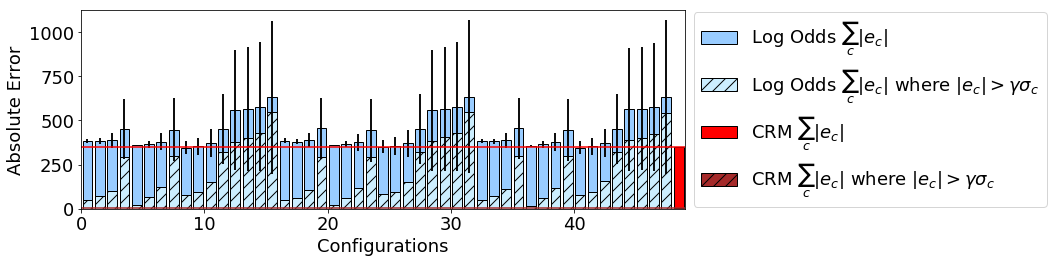

In [181]:
%matplotlib inline

import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 18})
# ax.tick_params(axis='x', labelsize=20)
# ax.tick_params(axis='y'

fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"


k = 1.25

inconsistencies = []
labels = []
errors = []
errors_overconfident = []
smapInconsistency = 0
smapError = 0
smapError_overconfident = 0

lowest_overconfident_i = 0
lowest_overconfident_label = ""
lowest_overconfident = 1e100
lowest_inconsistency = 1e100
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
    errBelief = np.abs(np.array(stats.errorBelief))
    stdBelief = np.array(stats.stdBelief)
    errLogOdds = np.abs(np.array(stats.errorLogOdds))
    stdLogOdds = np.array(stats.stdLogOdds)
    
#     mask = (errLogOdds > 0.6) | (errBelief > 0.6)
#     errLogOdds = errLogOdds[mask]
#     stdLogOdds = stdLogOdds[mask]
#     errBelief = errBelief[mask]
#     stdBelief = stdBelief[mask]
    
    inconsistencies.append(np.sum([max(0., err - k * std) for err, std in zip(errLogOdds, stdLogOdds)]))
    errors.append(np.sum(errLogOdds))
    errors_overconfident.append(np.sum(errLogOdds[errLogOdds - k * stdLogOdds > 0]))
    label = "LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize)
    labels.append(label)
    print rnd, filename, label
    
    if errors_overconfident[-1] < lowest_overconfident:
        lowest_overconfident = errors_overconfident[-1]
        lowest_overconfident_i = rnd
        lowest_overconfident_label = label
    if inconsistencies[-1] < lowest_inconsistency:
        lowest_inconsistency = inconsistencies[-1]
    
#     if rnd == 4:
#         print [max(0., err - k * std) for (err, std) in zip(errLogOdds, stdLogOdds)]
#     print errors_overconfident[-1]
    #ax.plot(errLogOdds, color=colors[rnd], label=label)
    
    if rnd == 4: #len(filenames)-1:
        smapError = np.sum(errBelief)
        smapInconsistency = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])
#         smapError_overconfident = np.sum(errBelief[errBelief - k * stdBelief > 0])
        smapError_overconfident = np.sum([err for err, std in zip(errBelief, stdBelief) if err > k*std])

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="#99ccff", edgecolor="black", label="Log Odds $\sum_c |e_c|$")
#ax.bar(np.array(list(range(len(errors))))+.5, errors, color="#006699", ecolor="black")
ax.bar(np.array(list(range(len(errors))))+.5, errors_overconfident, color="#cceeff", edgecolor="black", hatch='//', label="Log Odds $\sum_c |e_c|$ where $|e_c| > \gamma \sigma_c$")
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])


ax.plot([0, len(errors)+2], [smapError,smapError], color="r")
ax.plot([0, len(errors)+2], [smapError_overconfident,smapError_overconfident], color="brown")

# ax.scatter(lowest_overconfident_i, 1, marker="D")

ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency], color="r", edgecolor="black", label="CRM $\sum_c |e_c|$")
#ax.bar([len(errors)+.5], [smapError], color="r", ecolor="black")
ax.bar([len(errors)+.5], [smapError_overconfident], color="brown", edgecolor="black", hatch='//', label="CRM $\sum_c |e_c|$ where $|e_c| > \gamma \sigma_c$")


ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="", ecolor="black")
    
#ax.set_title("Absolute Error / Inconsistency Evolution over different ISM Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configurations")
ax.set_xlim([0,len(errors)+1])
# ax.set_yscale( "log" )
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("ism_evaluation.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')

print "CRM Inconsistency:", smapInconsistency
print "CRM Overconfident:", smapError_overconfident
print "Best LO Inconsistency:", lowest_inconsistency
print "Best LO Overconfident:", lowest_overconfident, lowest_overconfident_label

0 gp_runs/stats_0.bag GP p1=-2.00 p2=-2.50 p3=-0.50
1 gp_runs/stats_1.bag GP p1=-2.00 p2=-2.50 p3=-1.00
2 gp_runs/stats_2.bag GP p1=-2.00 p2=-2.50 p3=-1.50
3 gp_runs/stats_3.bag GP p1=-2.00 p2=-3.50 p3=-0.50
4 gp_runs/stats_4.bag GP p1=-2.00 p2=-3.50 p3=-1.00
5 gp_runs/stats_5.bag GP p1=-2.00 p2=-3.50 p3=-1.50
6 gp_runs/stats_6.bag GP p1=-2.00 p2=-4.50 p3=-0.50
7 gp_runs/stats_7.bag GP p1=-2.00 p2=-4.50 p3=-1.00
8 gp_runs/stats_8.bag GP p1=-2.00 p2=-4.50 p3=-1.50
9 gp_runs/stats_9.bag GP p1=-2.50 p2=-2.50 p3=-0.50
10 gp_runs/stats_10.bag GP p1=-2.50 p2=-2.50 p3=-1.00
11 gp_runs/stats_11.bag GP p1=-2.50 p2=-2.50 p3=-1.50
12 gp_runs/stats_12.bag GP p1=-2.50 p2=-3.50 p3=-0.50
13 gp_runs/stats_13.bag GP p1=-2.50 p2=-3.50 p3=-1.00
14 gp_runs/stats_14.bag GP p1=-2.50 p2=-3.50 p3=-1.50
15 gp_runs/stats_15.bag GP p1=-2.50 p2=-4.50 p3=-0.50
16 gp_runs/stats_16.bag GP p1=-2.50 p2=-4.50 p3=-1.00
17 gp_runs/stats_17.bag GP p1=-2.50 p2=-4.50 p3=-1.50
18 gp_runs/stats_18.bag GP p1=-3.00 p2=-2.50 p3=

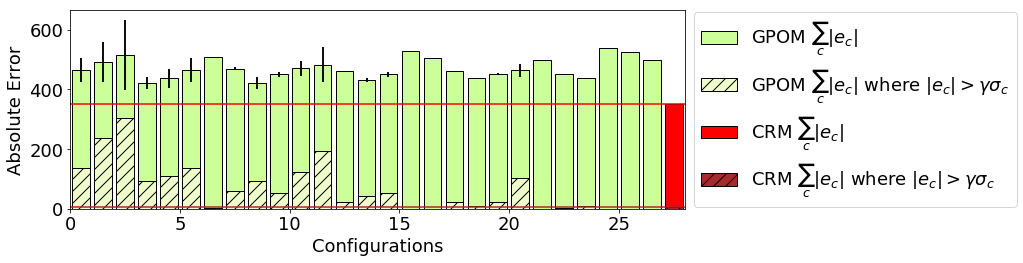

In [182]:
%matplotlib inline

import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 18})
# ax.tick_params(axis='x', labelsize=20)
# ax.tick_params(axis='y'

fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
# err_belief = []
# std_belief = []
err_GP = []
std_GP = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("gp_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("gp_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"


k = 1.25 #.1 #.25 #.25

inconsistencies = []
labels = []
errors = []
errors_overconfident = []
# smapInconsistency = 0
# smapError = 0
# smapError_overconfident = 0

lowest_overconfident_i = 0
lowest_overconfident_label = ""
lowest_overconfident = 1e100
lowest_inconsistency = 1e100
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
#     errBelief = np.abs(np.array(stats.errorBelief))
#     stdBelief = np.array(stats.stdBelief)
    errGP = np.abs(np.array(stats.errorGP))
    stdGP = np.array(stats.stdGP)
    
#     mask = (errGP > 0.6) | (errBelief > 0.6)
#     errGP = errGP[mask]
#     stdGP = stdGP[mask]
#     errBelief = errBelief[mask]
#     stdBelief = stdBelief[mask]
    
    inconsistencies.append(np.sum([max(0., err - k * std) for err, std in zip(errGP, stdGP)]))
    errors.append(np.sum(errGP))
    errors_overconfident.append(np.sum(errGP[errGP - k * stdGP > 0]))
    label = "GP p1=%.2f p2=%.2f p3=%.2f" % (stats.gpParameter1, stats.gpParameter2, stats.gpParameter3)
    labels.append(label)
    print rnd, filename, label
    
    if errors_overconfident[-1] < lowest_overconfident:
        lowest_overconfident = errors_overconfident[-1]
        lowest_overconfident_i = rnd
        lowest_overconfident_label = label
    if inconsistencies[-1] < lowest_inconsistency:
        lowest_inconsistency = inconsistencies[-1]
    
#     if rnd == 4:
#         print [max(0., err - k * std) for (err, std) in zip(errGP, stdGP)]
#     print errors_overconfident[-1]
    #ax.plot(errGP, color=colors[rnd], label=label)
    
#     if rnd == 4: #len(filenames)-1:
#         smapError = np.sum(errBelief)
#         smapInconsistency = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])
# #         smapError_overconfident = np.sum(errBelief[errBelief - k * stdBelief > 0])
#         smapError_overconfident = np.sum([err for err, std in zip(errBelief, stdBelief) if err > k*std])

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="#ccff99", edgecolor="black", label="GPOM $\sum_c |e_c|$")
#ax.bar(np.array(list(range(len(errors))))+.5, errors, color="#006699", ecolor="black")
ax.bar(np.array(list(range(len(errors))))+.5, errors_overconfident, color="#eeffcc", edgecolor="black", hatch='//', label="GPOM $\sum_c |e_c|$ where $|e_c| > \gamma \sigma_c$")
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])


ax.plot([0, len(errors)+2], [smapError,smapError], color="r")
ax.plot([0, len(errors)+2], [smapError_overconfident,smapError_overconfident], color="brown")

# ax.scatter(lowest_overconfident_i, 1, marker="D")

print "smapError", smapError
ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency], color="r", edgecolor="black", label="CRM $\sum_c |e_c|$")
#ax.bar([len(errors)+.5], [smapError], color="r", ecolor="black")
ax.bar([len(errors)+.5], [smapError_overconfident], color="brown", edgecolor="black", hatch='//', label="CRM $\sum_c |e_c|$ where $|e_c| > \gamma \sigma_c$")


ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="", ecolor="black")
    
#ax.set_title("Absolute Error / Inconsistency Evolution over different gp Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configurations")
ax.set_xlim([0,len(errors)+1])
# ax.set_yscale( "log" )
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("gp_evaluation.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')

print "CRM Inconsistency:", smapInconsistency
print "CRM Overconfident:", smapError_overconfident
print "Best GP Inconsistency:", lowest_inconsistency
print "Best GP Overconfident:", lowest_overconfident, lowest_overconfident_label

ISM inconsistency: 0.941646184342
0 LO inc=0.05 rs=0.05 ts=0.05
Smap Inconsistency: 38.8600354856
ISM inconsistency: 8.72816257825
1 LO inc=0.05 rs=0.05 ts=0.10
ISM inconsistency: 164.644464883
2 LO inc=0.05 rs=0.05 ts=0.30
ISM inconsistency: 2.8779574309
3 LO inc=0.05 rs=0.10 ts=0.05
ISM inconsistency: 23.4155212117
4 LO inc=0.05 rs=0.10 ts=0.10
ISM inconsistency: 184.050166428
5 LO inc=0.05 rs=0.10 ts=0.30
ISM inconsistency: 352.867204512
6 LO inc=0.05 rs=0.30 ts=0.05
ISM inconsistency: 383.472370821
7 LO inc=0.05 rs=0.30 ts=0.10
ISM inconsistency: 567.463288977
8 LO inc=0.05 rs=0.30 ts=0.30
ISM inconsistency: 1.42986856902
9 LO inc=0.20 rs=0.05 ts=0.05
ISM inconsistency: 9.53798161864
10 LO inc=0.20 rs=0.05 ts=0.10
ISM inconsistency: 164.282658597
11 LO inc=0.20 rs=0.05 ts=0.30
ISM inconsistency: 2.09493717158
12 LO inc=0.20 rs=0.10 ts=0.05
ISM inconsistency: 23.6938937873
13 LO inc=0.20 rs=0.10 ts=0.10
ISM inconsistency: 185.049270595
14 LO inc=0.20 rs=0.10 ts=0.30
ISM inconsistenc

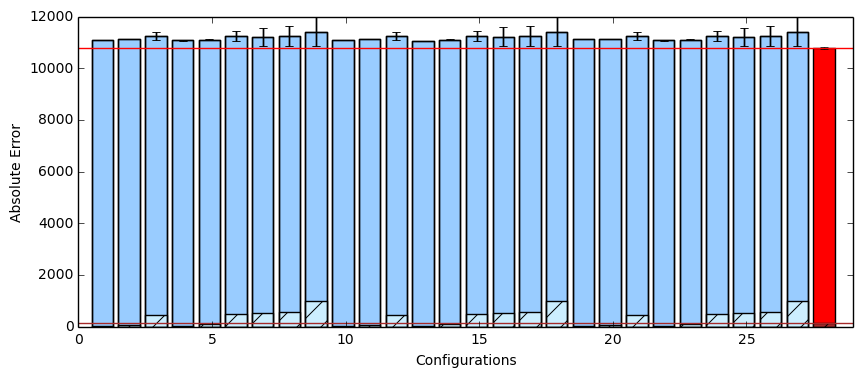

In [101]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/ism_runs_fewsteps_noise0.05/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/ism_runs_fewsteps_noise0.05/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"


k = 2

inconsistencies = []
labels = []
errors = []
errors_overconfident = []
smapInconsistency = 0
smapError = 0
smapError_overconfident = 0
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
    errLogOdds = np.abs(np.array(stats.errorFinalUpdatedLogOdds))
    stdLogOdds = np.array(stats.stdFinalUpdatedLogOdds)
    errBelief = np.abs(np.array(stats.errorFinalUpdatedBelief))
    stdBelief = np.array(stats.stdFinalUpdatedBelief)
    
#     mask = (errLogOdds > 0.6) | (errBelief > 0.6)
#     errLogOdds = errLogOdds[mask]
#     stdLogOdds = stdLogOdds[mask]
#     errBelief = errBelief[mask]
#     stdBelief = stdBelief[mask]
    
    inconsistencies.append(np.sum([max(0, err - k * std) for err, std in zip(errLogOdds, stdLogOdds)]))
    print "ISM inconsistency:", inconsistencies[-1]
    errors.append(np.sum(errLogOdds))
    errors_overconfident.append(np.sum(errLogOdds[errLogOdds - k * stdLogOdds > 0]))
    label = "LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize)
    labels.append(label)
    print rnd, label
    #ax.plot(errLogOdds, color=colors[rnd], label=label)
    
    if rnd == 0: #len(filenames)-1:
        smapError = np.sum(errBelief)
        smapInconsistency = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])
        smapError_overconfident = np.sum(errBelief[errBelief - k * stdBelief > 0])
        print "Smap Inconsistency:", smapInconsistency

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="#99ccff", ecolor="black")
#ax.bar(np.array(list(range(len(errors))))+.5, errors, color="#006699", ecolor="black")
ax.bar(np.array(list(range(len(errors))))+.5, errors_overconfident, color="#cceeff", hatch='/')
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])


ax.plot([0, len(errors)+2], [smapError,smapError], color="r")
ax.plot([0, len(errors)+2], [smapError_overconfident,smapError_overconfident], color="brown")

ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency], color="r", ecolor="black")
#ax.bar([len(errors)+.5], [smapError], color="r", ecolor="black")
ax.bar([len(errors)+.5], [smapError_overconfident], color="brown", ecolor="black", hatch='/')


ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="", ecolor="black")
    
#ax.set_title("Absolute Error / Inconsistency Evolution over different ISM Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configurations")
ax.set_xlim([0,len(errors)+2])
ax.legend()
plt.savefig("ism_evaluation.pdf")

0 LO inc=0.05 rs=0.03 ts=0.03
Smap Inconsistency: 0
1 LO inc=0.05 rs=0.03 ts=0.05
2 LO inc=0.05 rs=0.03 ts=0.10
3 LO inc=0.05 rs=0.03 ts=0.30
4 LO inc=0.05 rs=0.05 ts=0.03
5 LO inc=0.05 rs=0.05 ts=0.05
6 LO inc=0.05 rs=0.05 ts=0.10
7 LO inc=0.05 rs=0.05 ts=0.30
8 LO inc=0.05 rs=0.10 ts=0.03
9 LO inc=0.05 rs=0.10 ts=0.05
10 LO inc=0.05 rs=0.10 ts=0.10
11 LO inc=0.05 rs=0.10 ts=0.30
12 LO inc=0.05 rs=0.30 ts=0.03
13 LO inc=0.05 rs=0.30 ts=0.05
14 LO inc=0.05 rs=0.30 ts=0.10
15 LO inc=0.05 rs=0.30 ts=0.30
16 LO inc=0.25 rs=0.03 ts=0.03
17 LO inc=0.25 rs=0.03 ts=0.05
18 LO inc=0.25 rs=0.03 ts=0.10
19 LO inc=0.25 rs=0.03 ts=0.30
20 LO inc=0.25 rs=0.05 ts=0.03
21 LO inc=0.25 rs=0.05 ts=0.05
22 LO inc=0.25 rs=0.05 ts=0.10
23 LO inc=0.25 rs=0.05 ts=0.30
24 LO inc=0.25 rs=0.10 ts=0.03
25 LO inc=0.25 rs=0.10 ts=0.05
26 LO inc=0.25 rs=0.10 ts=0.10
27 LO inc=0.25 rs=0.10 ts=0.30
28 LO inc=0.25 rs=0.30 ts=0.03
29 LO inc=0.25 rs=0.30 ts=0.05
30 LO inc=0.25 rs=0.30 ts=0.10
31 LO inc=0.25 rs=0.30 ts=0

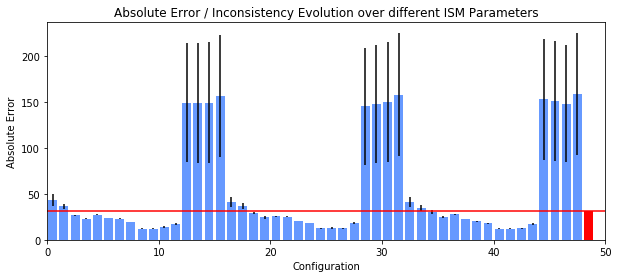

In [6]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"

inconsistencies = []
labels = []
errors = []
smapInconsistency = 0
smapError = 0
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
    if stats.ismRampSize > .5:
        continue
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
#     errLogOdds = np.abs(np.array(stats.errorFinalUpdatedLogOdds))
#     errBelief = np.abs(np.array(stats.errorFinalUpdatedBelief))
#     stdLogOdds = np.array(stats.stdFinalUpdatedLogOdds)
#     stdBelief = np.array(stats.stdFinalUpdatedBelief)
    
    
#     errLogOdds = np.abs(np.array(stats.errorLogOdds))
#     errBelief = np.abs(np.array(stats.errorBelief))
#     stdLogOdds = np.array(stats.stdLogOdds)
#     stdBelief = np.array(stats.stdBelief)
    
#     prior_error = np.nonzero((np.abs(errLogOdds - .5) > 0.01) & (np.abs(errBelief - .5) > 0.01))
#     #print len(prior_error[0])
    
#     errLogOdds = errLogOdds[prior_error]
#     errBelief = errBelief[prior_error]
#     stdLogOdds = stdLogOdds[prior_error]
#     stdBelief = stdBelief[prior_error]
    
    errLogOdds = np.abs(np.array(stats.errorCompleteUpdatedLogOdds[-stats.updatedVoxels[-1]:]))
    errBelief = np.abs(np.array(stats.errorCompleteUpdatedBelief[-stats.updatedVoxels[-1]:]))
    stdLogOdds = np.array(stats.stdCompleteUpdatedLogOdds[-stats.updatedVoxels[-1]:])
    stdBelief = np.array(stats.stdCompleteUpdatedBelief[-stats.updatedVoxels[-1]:])
    
    k = 1
    inconsistencies.append(np.sum([max(0, err - k * std) for err, std in zip(errLogOdds, stdLogOdds)]))
    errors.append(np.sum(errLogOdds))
    label = "LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize)
    print rnd, label
    labels.append(label)
    #ax.plot(errLogOdds, color=colors[rnd], label=label)
    
    if rnd == 0:
        smapError = np.sum(errBelief)
        smapInconsistency = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])
        print "Smap Inconsistency:", smapInconsistency

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=np.array(inconsistencies)/2, color="#6699ff", ecolor="black")
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])

ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency/2], color="r", ecolor="black")

ax.plot([0, len(errors)+2], [smapError,smapError], color="r")
    
ax.set_title("Absolute Error / Inconsistency Evolution over different ISM Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configuration")
ax.set_xlim([0,len(errors)+2])
ax.legend()
plt.savefig("ism_evaluation.pdf")